# RetailMart - Regressioanalyysi
Data http://media.wiley.com/product_ancillary/6X/11186614/DOWNLOAD/ch06.zip, RetailMart.xlsx

Tavoitteena on ostohistorian perusteella ennustaa, onko henkilö raskaana. Tätä voidaan käyttää kohdennetussa mainostamisessa.

## Datan lataaminen ja esikäsittely

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import graphviz

In [2]:
#apufunktio datan lataamiseen ja käsittelyyn
def load_data(filename: str, process: bool) -> pd.DataFrame():
    df = pd.read_csv(filename)
    if not process:
        return df
    if process:
        return preprocess(df)

def preprocess(df: pd.DataFrame()) -> pd.DataFrame():
    df_tmp_1 = pd.get_dummies(df['Implied Gender'], prefix='Gender', prefix_sep='_', drop_first=False)
    df_tmp_2 = pd.get_dummies(df['Home/Apt/ PO Box'], prefix='Residency', prefix_sep='_', drop_first=False)
    df_final = df_customers_dummied = pd.concat([df_tmp_1, df_tmp_2, df.iloc[:,2::]],axis=1)
    return df_final
    

In [3]:
df_customers_dummied = load_data('./Data/Pregnancy.csv', process=True)
df_customers_dummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Gender_F                1000 non-null   uint8
 1   Gender_M                1000 non-null   uint8
 2   Gender_U                1000 non-null   uint8
 3   Residency_A             1000 non-null   uint8
 4   Residency_H             1000 non-null   uint8
 5   Residency_P             1000 non-null   uint8
 6   Pregnancy Test          1000 non-null   int64
 7   Birth Control           1000 non-null   int64
 8   Feminine Hygiene        1000 non-null   int64
 9   Folic Acid              1000 non-null   int64
 10  Prenatal Vitamins       1000 non-null   int64
 11  Prenatal Yoga           1000 non-null   int64
 12  Body Pillow             1000 non-null   int64
 13  Ginger Ale              1000 non-null   int64
 14  Sea Bands               1000 non-null   int64
 15  Stopped buying ciggies

In [4]:
#Training data
X_train = df_customers_dummied.iloc[:, :-1]
y_train = df_customers_dummied.iloc[:, -1].astype('category')

## Logistisen regressiomallin hyperparametrien optimisaatio

In [5]:
model = LogisticRegression()
#Design of Experiments
solvers = ['newton-cg', 'lbfgs', 'liblinear'] #Ratkaisualgoritmi
penalties = ['l2'] #Regularisaatiofunktio, riippuu ratkaisualgoritmista joten ei vielä testata sitä vaan valitaan yleisin l2-regularisaatio
C_values = [0.001, 0.01, 0.1, 1, 10, 100] #Regularisaation voimakkuus

grid = dict(solver=solvers, penalty=penalties, C=C_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
grid_search = GridSearchCV(estimator=model, 
                          param_grid = grid,
                          n_jobs = 1,
                          cv=cv,
                          scoring='accuracy',
                          error_score=0)
grid_result = grid_search.fit(X_train, y_train)

#Summa summarum
print(f"Paras tulos: {grid_result.best_score_:.5f} parametreilla {grid_result.best_params_} \n")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
    print(f"Tulos (ka): {mean:.5f} (std:{stdev:.3f}), parametrit {param}.")

Paras tulos: 0.82900 parametreilla {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'} 

Tulos (ka): 0.76240 (std:0.048), parametrit {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}.
Tulos (ka): 0.76240 (std:0.048), parametrit {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}.
Tulos (ka): 0.76500 (std:0.048), parametrit {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}.
Tulos (ka): 0.76600 (std:0.046), parametrit {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}.
Tulos (ka): 0.76600 (std:0.046), parametrit {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}.
Tulos (ka): 0.76660 (std:0.047), parametrit {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}.
Tulos (ka): 0.82020 (std:0.040), parametrit {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}.
Tulos (ka): 0.82020 (std:0.040), parametrit {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}.
Tulos (ka): 0.81840 (std:0.039), parametrit {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}.
Tulos (ka): 0.82900 (std:0.040), parametrit {'C': 1, 

## Mallin luominen

In [6]:
logreg = LogisticRegression(C=1, penalty='l2', solver='lbfgs')

Testi datan lataaminen ja käsittely

In [7]:
test_df = load_data('./Data/Pregnancy_Test.csv', process=True)
X_test = df_customers_dummied.iloc[:, :-1]
y_test = df_customers_dummied.iloc[:, -1].astype('category')

In [8]:
#Mallin sovittaminen
logreg.fit(X_train, y_train)

LogisticRegression(C=1)

## Mallin arviointi

In [9]:
#Mallin testaaminen testidataa vasten
y_pred = logreg.predict(X_test)


In [10]:
#Mallin tarkkuus testidataa vasten
print(f"Tarkkuus: {metrics.accuracy_score(y_test, y_pred)*100}%")

Tarkkuus: 83.6%


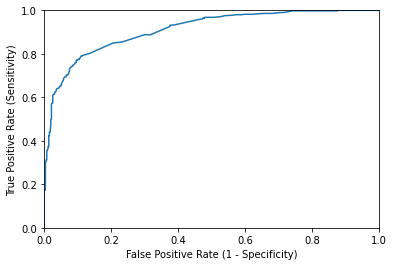

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()


In [12]:
print(f"AUC: {metrics.roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])}")

AUC: 0.9106960000000001


Text(0.5, 1.0, 'Mallin arvio vs. oikea arvo')

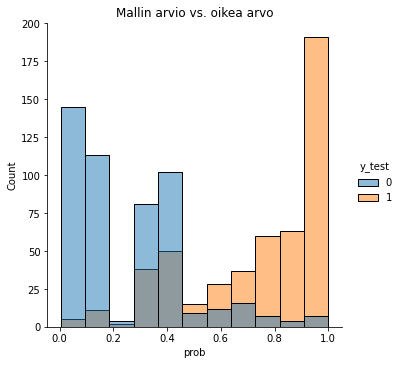

In [13]:
df_predictions = pd.DataFrame({'prob': logreg.predict_proba(X_test)[:,1], 'y_test': y_test})

plot = sns.displot(df_predictions, x='prob', hue='y_test')
plt.title("Mallin arvio vs. oikea arvo")

# Random Forest luokittelija

In [14]:
forest_classifier = RandomForestClassifier(n_estimators = 10, n_jobs=1)
forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=1)

In [15]:
forest_y_pred = forest_classifier.predict(X_test)
forest_y_pred_proba = forest_classifier.predict_proba(X_test)
#Tarkkuus
print(f"Tarkkuus: {metrics.accuracy_score(y_test, forest_y_pred)*100}%")

Tarkkuus: 86.6%


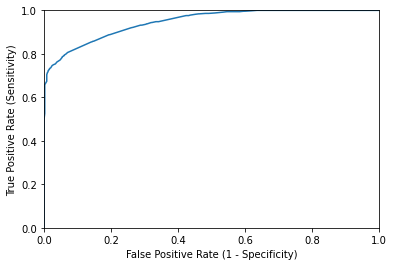

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, forest_y_pred_proba[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [17]:
print(f"AUC: {metrics.roc_auc_score(y_test, forest_y_pred_proba[:,1])}")

AUC: 0.946462


Text(0.5, 1.0, 'Piirteiden painoarvot luokittelussa')

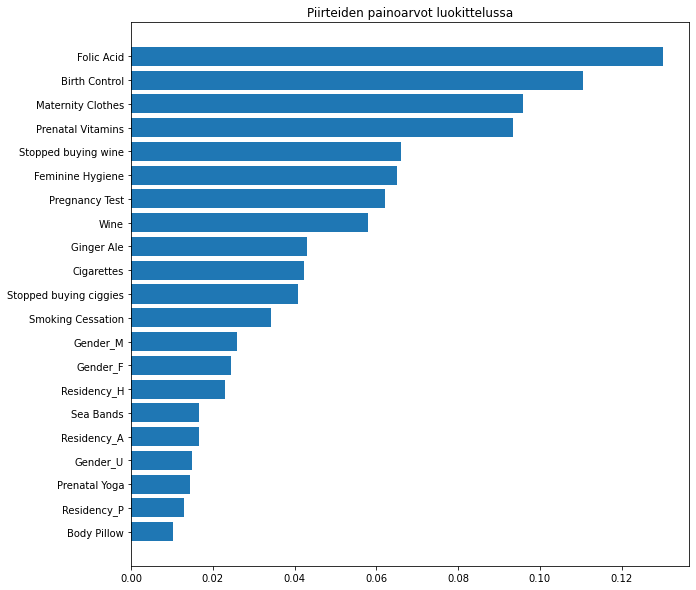

In [18]:
df_f_importance = pd.DataFrame({"Feature": list(X_train.columns),
                                "Importance": forest_classifier.feature_importances_})
df_f_importance = df_f_importance.sort_values(by=['Importance'],ascending= True)
fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.barh(y=df_f_importance['Feature'], width=df_f_importance['Importance'])
ax2.set_title('Piirteiden painoarvot luokittelussa')